### Setup Environment:

In [1]:
from src.embeddings import load_data, split_dataset, train_and_evaluate_model

# Class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import os

# Models
# Random forest
from sklearn.ensemble import RandomForestClassifier
# Logistic regression
from sklearn.linear_model import LogisticRegression
# Support vector machine
from sklearn.svm import SVC
# Decision tree
from sklearn.tree import DecisionTreeClassifier

## Evaluate the Embeddings

In [2]:
def run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, NORMAL=False, DR_ICDR_3=False, quality=False):
    
    # Get the dataset
    if quality:
        X_quality, y_quality, X_bad_quality, y_bad_quality = load_data(labels_path=LABELS_PATH, backbone=EMBEDDINGS_BACKBONE, label=LABEL, directory=EMBEDDINGS_DIR, normal=NORMAL, DR_ICDR_3=DR_ICDR_3, quality=quality)
    else:    
        X, y = load_data(labels_path=LABELS_PATH, backbone=EMBEDDINGS_BACKBONE, label=LABEL, directory=EMBEDDINGS_DIR, normal=NORMAL, DR_ICDR_3=DR_ICDR_3, quality=quality)

    if quality:
        X_train_quality, X_test_quality, y_train_quality, y_test_quality = split_dataset(X_quality, y_quality, test_size=TEST_SIZE)
        X_train_bad_quality, X_test_bad_quality, y_train_bad_quality, y_test_bad_quality = split_dataset(X_bad_quality, y_bad_quality, test_size=TEST_SIZE)
        # Check if any of the resulting datasets is None
        if X_train_quality is None or X_test_quality is None or y_train_quality is None or y_test_quality is None:
            return None
        if X_train_bad_quality is None or X_test_bad_quality is None or y_train_bad_quality is None or y_test_bad_quality is None:
            return None
        X_train = np.concatenate((X_train_quality, X_train_bad_quality))
        y_train = np.concatenate((y_train_quality, y_train_bad_quality))
        
    else:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=TEST_SIZE)
    
    if quality:
        # Train and evaluate with good and bad quality subsets
        print('#'*50, ' GOOD QUALITY ', '#'*50)
        # Define a list of models to test
        if CLASS_WEIGTHS:
            class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
            # Create a dictionary from class labels and weights
            class_weights = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
            print(f'Setting class weigths to: {class_weights}')

            models = [
                #("SVM", SVC(class_weight=class_weights, probability=True)),
                ("Logistic Regression", LogisticRegression(class_weight=class_weights)),
                #('Decision Tree', DecisionTreeClassifier(class_weight=class_weights)),
            ]
        else:
            models = [
                #("SVM", SVC(probability=True)),
                ("Logistic Regression", LogisticRegression())
                #('Decision Tree', DecisionTreeClassifier()),
            ]
        # Run the experiments
        print('#'*50, ' Train all evaluate good quality ', '#'*50)
        model, wrong_indices_good = train_and_evaluate_model(X_train, X_test_quality, y_train, y_test_quality, models=models)
        
        print('#'*50, ' Train all evaluate bad quality ', '#'*50)
        model, wrong_indices_bad = train_and_evaluate_model(X_train, X_test_bad_quality, y_train, y_test_bad_quality, models=models)

    
        return wrong_indices_good, wrong_indices_bad
        
    else:
        # Define a list of models to test
        if CLASS_WEIGTHS:
            class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
            # Create a dictionary from class labels and weights
            class_weights = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
            print(f'Setting class weigths to: {class_weights}')

            models = [
                #("SVM", SVC(class_weight=class_weights, probability=True)),
                ("Logistic Regression", LogisticRegression(class_weight=class_weights)),
                ('Decision Tree', DecisionTreeClassifier(class_weight=class_weights)),
            ]
        else:
            models = [
                #("SVM", SVC(probability=True)),
                ("Logistic Regression", LogisticRegression())
                ('Decision Tree', DecisionTreeClassifier()),
            ]

        # Run the experiments
        model, wrong_indices = train_and_evaluate_model(X_train, X_test, y_train, y_test, models=models)
        
        return wrong_indices

#### Constants

In [3]:
# Constants:
LABELS_PATH = '/home/opc/Retina/BRSET/labels.csv'
EMBEDDINGS_BACKBONE = 'dinov2_large'
EMBEDDINGS_DIR = 'Embeddings'
TEST_SIZE = 0.3
CLASS_WEIGTHS = True
# 'focus', 'iluminaton', 'image_field', 'artifacts'
quality = 'artifacts'

### Sex Prediction

Training set size is: 39 rows and 1024 columns
Test set size is: 18 rows and 1024 columns


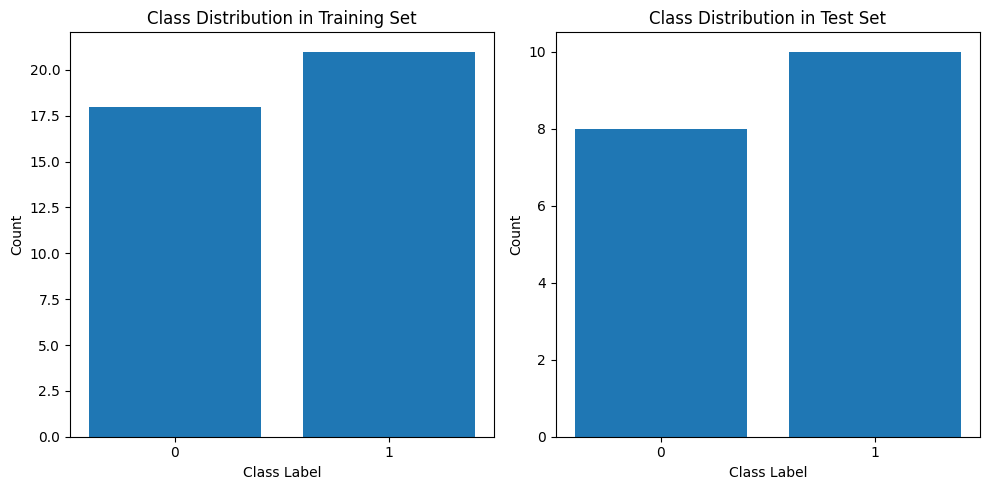

Training set size is: 11346 rows and 1024 columns
Test set size is: 4863 rows and 1024 columns


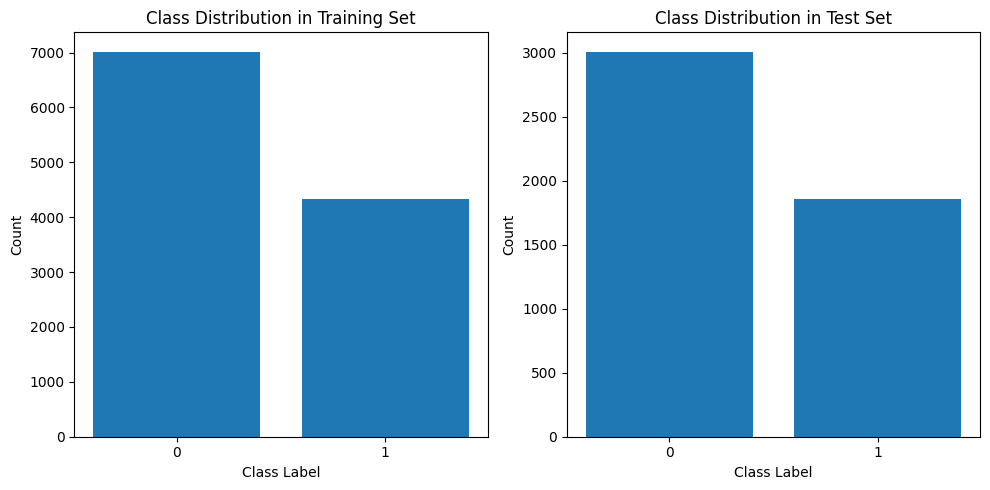

##################################################  GOOD QUALITY  ##################################################
Setting class weigths to: {0: 0.8090534394542354, 1: 1.308921591170384}
##################################################  Train all evaluate good quality  ##################################################


####################  Logistic Regression  ####################


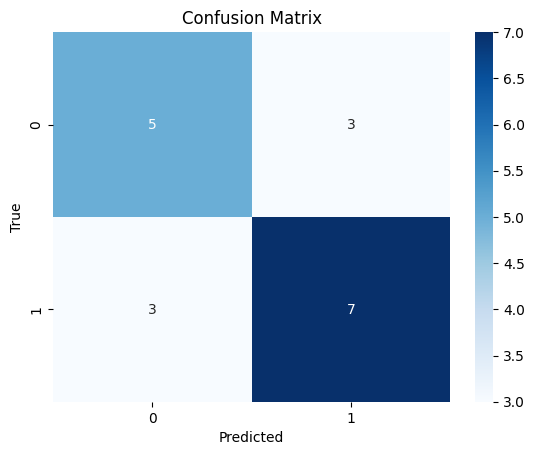

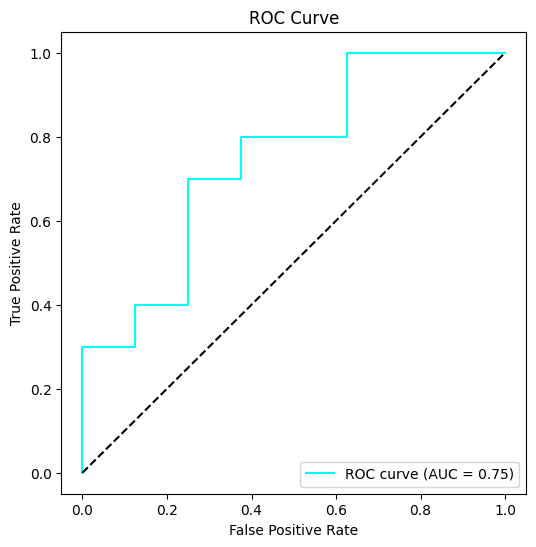

              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.70      0.70      0.70        10

    accuracy                           0.67        18
   macro avg       0.66      0.66      0.66        18
weighted avg       0.67      0.67      0.67        18

##################################################  Train all evaluate bad quality  ##################################################


####################  Logistic Regression  ####################


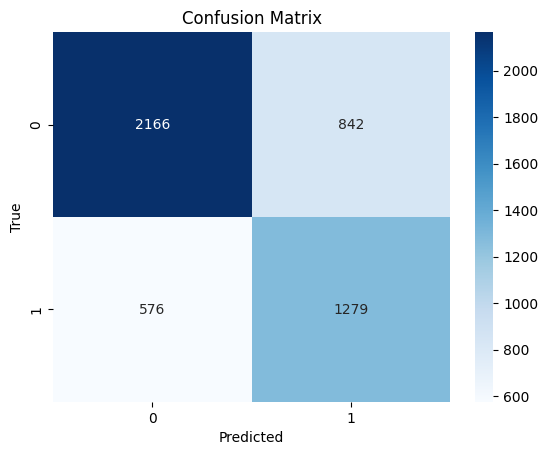

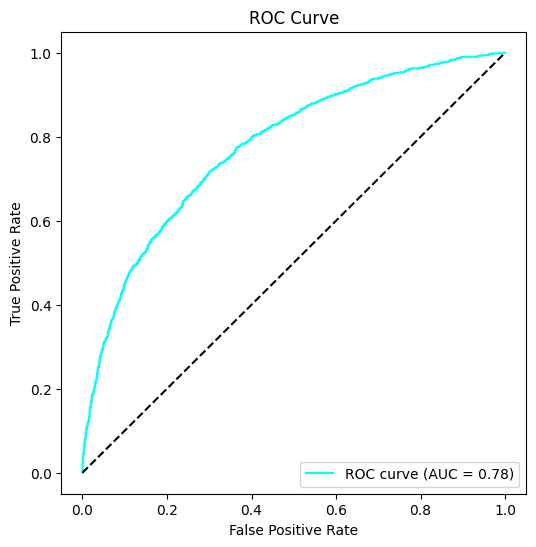

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      3008
           1       0.60      0.69      0.64      1855

    accuracy                           0.71      4863
   macro avg       0.70      0.70      0.70      4863
weighted avg       0.72      0.71      0.71      4863



In [4]:
LABEL = 'patient_sex'

wrong_indices_good, wrong_indices_bad = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, quality=quality)

## Diabetic Retinopathy

### 5 Class

In [5]:
LABEL = 'DR_ICDR'
DR_ICDR_3 = False

try:
    wrong_indices_good, wrong_indices_bad = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, DR_ICDR_3=DR_ICDR_3, quality=quality)
    print(wrong_indices_good, wrong_indices_bad)
except:
    print('Error with DR_ICDR')

Error with DR_ICDR


### 3 Class

In [8]:
LABEL = 'DR_ICDR'
DR_ICDR_3 = False

try:
    wrong_indices_good, wrong_indices_bad = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, DR_ICDR_3=DR_ICDR_3, quality=quality)
    print(wrong_indices_good, wrong_indices_bad)
except:
    print('Error with DR_ICDR')

Error with DR_ICDR


### 2 Class

Training set size is: 39 rows and 1024 columns
Test set size is: 18 rows and 1024 columns


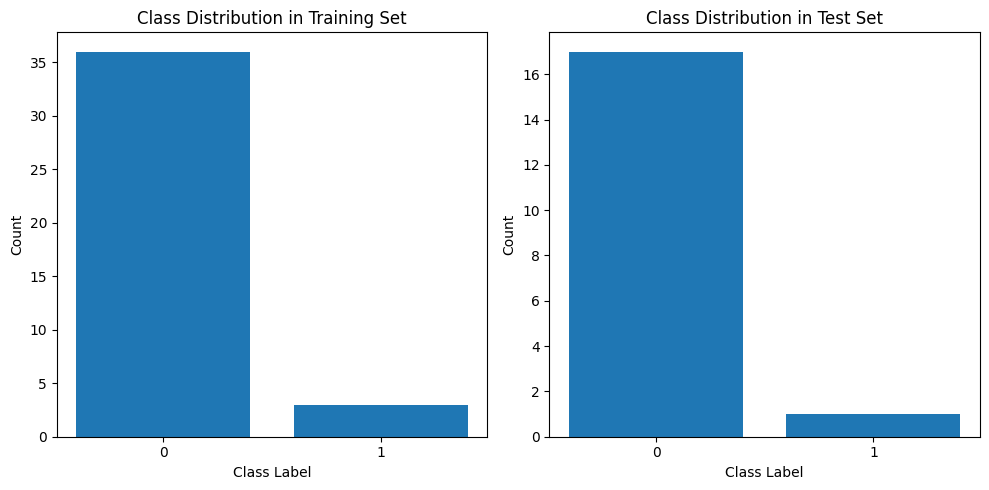

Training set size is: 11346 rows and 1024 columns
Test set size is: 4863 rows and 1024 columns


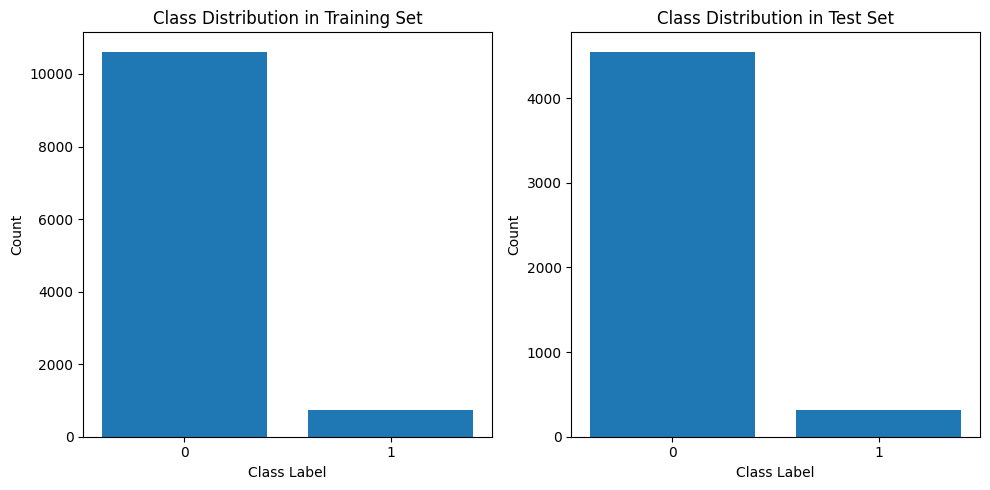

##################################################  GOOD QUALITY  ##################################################
Setting class weigths to: {0: 0.5343565192903408, 1: 7.776639344262295}
##################################################  Train all evaluate good quality  ##################################################


####################  Logistic Regression  ####################


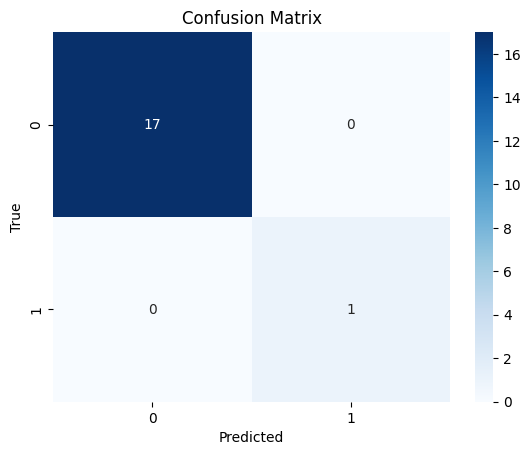

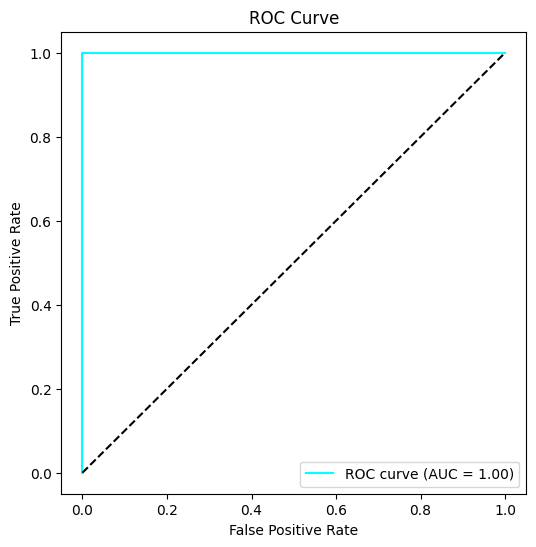

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         1

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

##################################################  Train all evaluate bad quality  ##################################################


####################  Logistic Regression  ####################


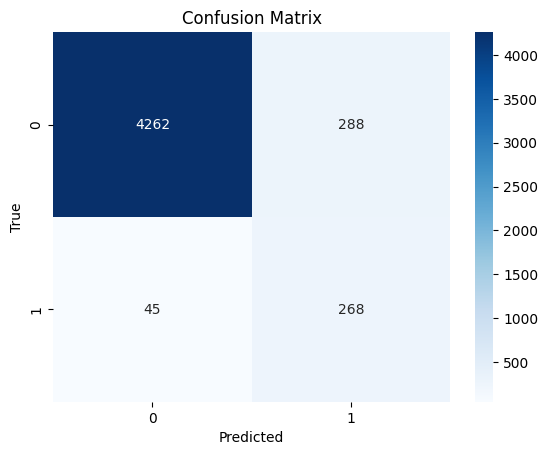

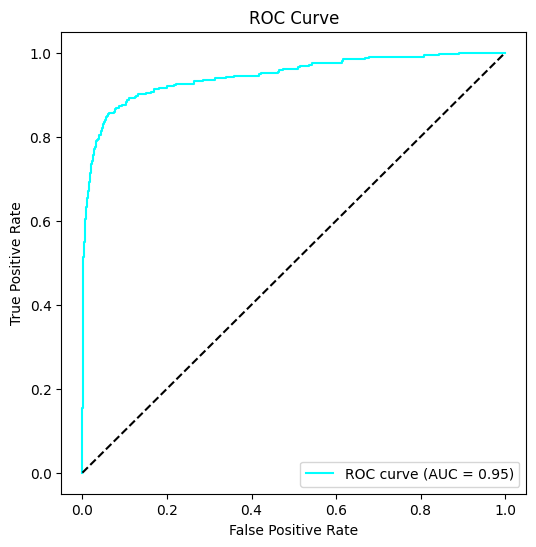

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      4550
           1       0.48      0.86      0.62       313

    accuracy                           0.93      4863
   macro avg       0.74      0.90      0.79      4863
weighted avg       0.96      0.93      0.94      4863



(Index([], dtype='int64'),
 Index([ 9835,  5591, 14479,   538,  7363, 12018,  1016,   225,  7839,  3899,
        ...
         8771, 14139, 14378,   105,  7850,    33,  2394,  9338,  6087, 10863],
       dtype='int64', length=333))

In [9]:
LABEL = 'diabetic_retinopathy'
run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, quality=quality)

### get from wrong indices some images

In [10]:
ref_file = pd.read_csv(LABELS_PATH)
ref_file

image_id  patient_id    camera  patient_age comorbidities  \
0      img00001           1  Canon CR         48.0     diabetes1   
1      img00002           1  Canon CR         48.0     diabetes1   
2      img00003           2  Canon CR         18.0     diabetes1   
3      img00004           2  Canon CR         18.0     diabetes1   
4      img00005           3  Canon CR         22.0     diabetes1   
...         ...         ...       ...          ...           ...   
16261  img16262        8522  Canon CR         33.0     diabetes1   
16262  img16263        8523  Canon CR         19.0     diabetes1   
16263  img16264        8523  Canon CR         19.0     diabetes1   
16264  img16265        8524  Canon CR         20.0     diabetes1   
16265  img16266        8524  Canon CR         20.0     diabetes1   

      diabetes_time_y insuline  patient_sex  exam_eye diabetes  ... amd  \
0                  12      yes            1         1      yes  ...   0   
1                  12      yes            1         2      yes  ...   0   
2                   7      yes            2         1      yes  ...   0   
3                   7      yes            2         2      yes  ...   0   
4                  11      yes            1         1      yes  ...   0   
...               ...      ...          ...       ...      ...  ...  ..   
16261              14      yes            1         2      yes  ...   0   
16262               4      yes            1         1      yes  ...   0   
16263               4      yes            1         2      yes  ...   0   
16264             NaN      yes            1         1      yes  ...   0   
16265             NaN      yes            1         2      yes  ...   0   

      vascular_occlusion  hypertensive_retinopathy  drusens  hemorrhage  \
0                      0                         0        0           0   
1                      0                         0        0           0   
2                      0                         0        0           0   
3                      0                         0        0           0   
4                      0                         0        0           0   
...                  ...                       ...      ...         ...   
16261                  0                         0        0           0   
16262                  0                         0        0           0   
16263                  0                         0        0           0   
16264                  0                         0        0           0   
16265                  0                         0        0           0   

       retinal_detachment  myopic_fundus  increased_cup_disc  other   quality  
0                       0              0                   1      0  Adequate  
1                       0              0                   1      0  Adequate  
2                       0              0                   0      0  Adequate  
3                       0              0                   0      0  Adequate  
4                       0              0                   0      0  Adequate  
...                   ...            ...                 ...    ...       ...  
16261                   0              0                   1      0  Adequate  
16262                   0              0                   0      0  Adequate  
16263                   0              0                   0      0  Adequate  
16264                   0              0                   1      0  Adequate  
16265                   0              0                   0      0  Adequate  

[16266 rows x 34 columns]

In [11]:
# filter in the ref_file index in the wrong_indices_good
# get from that 5 random images per each class in CR_ICDR
ref_file.iloc[wrong_indices_good].groupby('DR_ICDR').apply(lambda x: x.sample(5, replace=True)).to_csv('wrong_indices_good.csv')

In [12]:
# filter in the ref_file index in the wrong_indices_good
# get from that 5 random images per each class in CR_ICDR
ref_file.iloc[wrong_indices_bad].groupby('DR_ICDR').apply(lambda x: x.sample(min(len(x), 5))).to_csv('wrong_indices_bad.csv')